# Testing Revolve checkpointing: simplified Full Waveform Inversion (FWI)

In essence, FWI consists of a local optimisation, where the goal is to minimise the misfit between true/observed data and predicted/computed data. The misfit function can be measured by the $L^2$ norm, which may be written as, in a continuous space,
$$
    I (\mathbf{m})\equiv \frac{1}{2} \int_{\tau} \int_{\Omega_0} \mathbf{d}^2(\mathbf{m})\boldsymbol{\delta}(\mathbf{x}- \check{\mathbf{x}})\, \text{d} \mathcal{V} \text{d} t,
$$
where $\mathbf{d}$ gives the difference between the predicted and observed data, both recorded at a set of receivers located at the point positions $\check{\mathbf{x}} \in \Omega_{0}$, in a time interval $\tau\equiv[t_0, t_f]\subset \mathbb{R}$, with $t_0$ the initial time and $t_f$ the final time. The spatial domain of interest (usually two- or three-dimensional) is set as $\Omega_{0}$. The term $\boldsymbol{\delta}(\mathbf{x}- \check{\mathbf{x}})$ is the delta Dirac function to model the receiver point positions. The predicted  seismograms' data, $\mathbf{u}$, is governed by a wave equation. 

## Wave equation
The acoustic wave equation reads:
$$\frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} -\nabla^{2}p = f,$$
where $p = p(c, \mathbf{x}, t)$ is the wave pressure, $\nabla^{2}(\cdot)$ represents the Laplacian operator with respect to $\mathbf{x} \in \Omega_0$, $v_p = v_p(\mathbf{x}):\Omega_{0}\rightarrow \mathbb{R}$ is the pressure wave ($P$-wave) velocity, which is assumed to be piecewise-constant and positive. The external force term $f = f(\mathbf{x},t):\Omega_{0}\rightarrow \mathbb{R}$, models the source of waves and is usually described by a Ricker Wavelet.

## Implementation

We begin by importing `firedrake`, `firedrake.adjoint` to compute the adjoint-based gradient automatically, and the Revolve algorithm from checkpoint_schedules.

In [1]:
from firedrake import *
from firedrake.adjoint import *
from checkpoint_schedules import Revolve

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


We can now proceed to set up the problem. We choose a resolution and set up a unit square mesh and degree 3 KMV elemts.

In [2]:
mesh = UnitSquareMesh(100, 100)
element = FiniteElement("KMV", mesh.ufl_cell(), degree=1, variant="KMV")
V = FunctionSpace(mesh, element)

We consider only one receiver located ate $\check{\mathbf{x}} = [0.15,0.2]$ and one source located at $\mathbf{x}_s = [0.1,0.2]$. 

In [3]:
import numpy as np
rec_location = np.linspace((0.15, 0.2), (0.15, 0.8), 20)
source_location = np.linspace((0.1, 0.2), (0.1, 0.8), 1)

Next, we choose the end step and the time-step adopted in the texts.

In [4]:
tf = 0.5
dt = 0.001

We compute the Ricker wavelet for every time-step. `full_ricker_wavelet` returns the forcing term $f(\mathbf{x}, t)$ of the acoustic wave equation.

In [5]:
def full_ricker_wavelet(dt, tf, freq, amp=1.0):
    """Compute the Ricker wavelet optionally applying low-pass filtering
    using cutoff frequency in Hertz.
    """
    nt = int(tf / dt)  # number of timesteps
    time = 0.0
    amp = 1.0
    delay = 1.5
    full_wavelet = np.zeros((nt,))
    for t in range(nt):
        t0 = t - delay * np.sqrt(6.0) / (np.pi * freq)
        rw = (amp * (1.0 - (1.0 / 2.0) * (2.0 * np.pi * freq) * (2.0 * np.pi * freq) * t0 * t0)
                * np.exp(
                    (-1.0 / 4.0) * (2.0 * np.pi * freq) * (2.0 * np.pi * freq) * t0 * t0
                )
            )
        full_wavelet[t] = rw
        time += dt
    return full_wavelet

The acoustic velocity model is created with the function `make_vp_circle`.

In [6]:
def make_vp_circle(vp_guess=False):
    """Acoustic velocity model"""
    x, z = SpatialCoordinate(mesh)
    if vp_guess:
        vp = Function(V).interpolate(1.5 + 0.0 * x)
    else:
        vp = Function(V).interpolate(
            2.5
            + 1 * tanh(100 * (0.125 - sqrt((x - 0.5) ** 2 + (z - 0.5) ** 2)))
        )
    return vp

The function `forcing` models the acoustic wave equation forcing $f(\mathbf{x}, t)$.

In [7]:
def forcing():
    z, x = SpatialCoordinate(mesh)
    x_0 = source_location[0]
    delta = exp(-2000 * ((z - x_0[0]) ** 2 + (x - x_0[1]) ** 2))
    f = Function(V, name="g").interpolate(delta)
    return f

The receivers are located at some points in the space. They get the wave data that arrives at this point. In Firedrake, the receivers are defined by using `VertexOnlyMesh`. The receiver data are obtained by interpolating the wave equation solution function in the receivers.

The `create_receiver` creates the receiver mesh and the interpolator....

In [8]:
def create_receiver(wave_eq_solution):
    mesh_rec = VertexOnlyMesh(mesh, rec_location)
    P = FunctionSpace(mesh_rec, "DG", 0)
    return Interpolator(wave_eq_solution, P), P



We then write the forward solver, which is able to compute acoustic wave equation and the cost function.

In [9]:
import finat
def forward_solver(c, compute_cost_function=False, true_rec=None, checkpointing=False):
    nt = int(tf / dt)  # number of timesteps
    u = TrialFunction(V)
    v = TestFunction(V)  # Test Function
    X = Function(V, name="X")
    p_n = Function(V, name="p_n")      # n
    p_nm1 = Function(V, name="p_nm1")      # n-1
    
    # time discretisation
    du2_dt2 = ((u - 2.0 * p_n + p_nm1) / dt ** 2)

    
    qr_x = finat.quadrature.make_quadrature(
            V.finat_element.cell, V.ufl_element().degree(), scheme="KMV"
        )
    
    f = forcing()
    t_term = du2_dt2 * v * dx(scheme=qr_x)
    l_term = c * c * dot(grad(p_n), grad(v)) * dx(scheme=qr_x)
    f_term = f * v * dx(scheme=qr_x)
    nf = c * ((p_n - p_nm1) / dt) * v * ds(scheme=None)
    FF = t_term + l_term - f_term + nf
    
    lhs_ = lhs(FF)
    rhs_ = rhs(FF)
    
    lin_var = LinearVariationalProblem(lhs_, rhs_, X)
    params = {
                "mat_type": "matfree", "ksp_type":
                "preonly", "pc_type": "jacobi"
                }
    # peak of the frequency for the ricker wavelet
    freq = 7
    wavelet = full_ricker_wavelet(dt, tf, freq)
    solver = LinearVariationalSolver(lin_var, solver_parameters=params)

    rec_interp, P = create_receiver(X)
    
    usol_recv = []
    J = 0.0
    t0 = dt
    
    def time_run(step, compute_cost_function):
        solver.solve()
        p_nm1.assign(p_n)
        p_n.assign(X)
        rec = Function(P, name="rec")
        rec_interp.interpolate(output=rec)
        if compute_cost_function:
            true_rec_func = Function(P, name="true_rec")
            true_rec_func.dat.data[:] = true_rec[step]
            misfit = rec - true_rec_func
            J0 = assemble(0.5*inner(misfit, misfit) * dx)
            return J0
        else:
            return rec

    if checkpointing:
        tape = get_working_tape()
        for t in tape.timestepper(np.arange(0, tf, float(dt))):
            if compute_cost_function:
                J += time_run(int(t/dt), compute_cost_function)
            else:
                rec = time_run(int(t/dt), compute_cost_function)
                usol_recv.append(rec.vector().gather()) 
    else:
        for t in np.arange(0, tf, float(dt)):
            if compute_cost_function:
                J += time_run(int(t/dt), compute_cost_function)
            else:
                rec = time_run(int(t/dt), compute_cost_function)
                usol_recv.append(rec.vector().gather())
    if compute_cost_function:
        return J
    else:
        return usol_recv

In [10]:
c = make_vp_circle()

Text(0.5, 1.0, 'Acoustic velocity model')

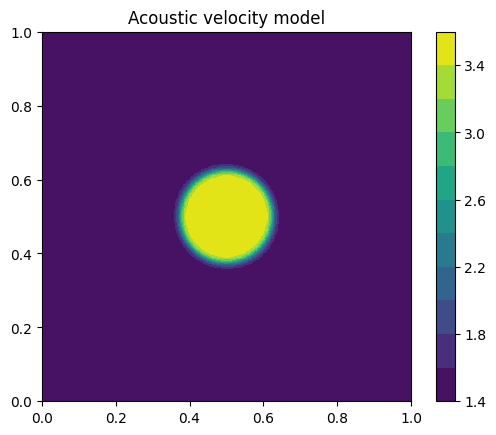

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
contours = tricontourf(c, 10, axes=axes)
fig.colorbar(contours, ax=axes, fraction=0.046)
axes.set_aspect("equal")
axes.set_title("Acoustic velocity model")

In [12]:
%%time
true_rec = forward_solver(c)

/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


CPU times: user 967 ms, sys: 84.7 ms, total: 1.05 s
Wall time: 1.79 s


In [13]:
def test_wave_equation(c_guess, true_rec, checkpointing=False, snaps_in_ram=None):
    nt = int(tf / dt)  # number of timesteps
    if checkpointing:
        tape = get_working_tape()
        tape.progress_bar = ProgressBar
        tape.enable_checkpointing(Revolve(nt, snaps_in_ram))
    J = forward_solver(c_guess, compute_cost_function=True, true_rec=true_rec, checkpointing=checkpointing)
    Jhat = ReducedFunctional(J, Control(c_guess))
    dJ = Jhat.derivative()
    Jhat(c_guess*0.9)
    # Test recompute forward model
    assert(np.allclose(Jhat(c_guess), J))

    dJbar = Jhat.derivative()
    # Test recompute adjoint-based gradient
    assert np.allclose(dJ.dat.data_ro[:], dJbar.dat.data_ro[:])

    # Taylor test
    h = Function(V)
    h.assign(1, annotate=False)
    assert taylor_test(Jhat, c_guess, h) > 1.9
    dJ = Jhat.derivative()
    return J, dJ

In [14]:
continue_annotation()

True

In [15]:
c_guess = make_vp_circle(vp_guess=True)

Text(0.5, 1.0, 'Acoustic velocity model')

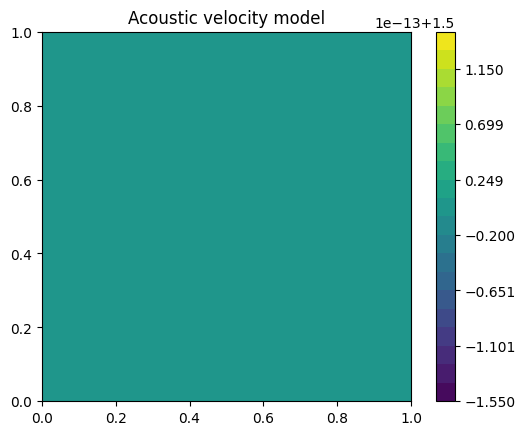

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
contours = tricontourf(c_guess, 20, axes=axes)
fig.colorbar(contours)
axes.set_aspect("equal")
axes.set_title("Acoustic velocity model")

In [17]:
%%time
tape = get_working_tape()
J0, dJ0 = test_wave_equation(c_guess, true_rec, checkpointing=False)
tape.clear_tape()

/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(valu

Running Taylor test
Computed residuals: [9.718101673783274e-09, 2.44934567771232e-09, 6.148208959519617e-10, 1.5401620164545774e-10]
Computed convergence rates: [1.9882781297165186, 1.9941582928079271, 1.9970840764430864]


/Users/ddolci/work/firedrake_main/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


CPU times: user 33.3 s, sys: 550 ms, total: 33.9 s
Wall time: 35.5 s


In [ ]:
J1, dJ1 = test_wave_equation(c_guess, true_rec, checkpointing=True, snaps_in_ram=100)
assert np.allclose(J0, J1)

Taping forward ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 1398/1398 [0:00:10]
Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 1398/1398 [0:00:10]
Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 1398/1398 [0:00:10]
Evaluating Functional ▣▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 45/500 [0:00:00]

Running Taylor test


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 500/500 [0:00:01]
Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▢▢▢▢▢▢▢▢ 427/500 [0:00:01]

In [ ]:
assert np.allclose(dJ0.dat.data_ro[:], dJ1.dat.data_ro[:])
assert np.allclose(J0, J1)
print("Test passed!")